# We all are from the same big family

In [1]:
from IPython.display import display, HTML
# Hide/Show input area
display(HTML(
"<script>$('.mytoggle').remove();$('.code_cell').prepend(\"<button style='width:32px' class='mytoggle' onclick=\'f(this)\'>&gt;</button>\");\
function f(e){$(e).parent().find('.input').toggle()}</script>"
))

In [101]:
%matplotlib inline
import numpy as np;
import matplotlib.pyplot as plt;

import scipy
import scipy.cluster.hierarchy as sch
from scipy import linalg, stats
from sklearn.decomposition import PCA

def rnorm(n,u,s):
    return np.random.standard_normal(n)*s+u

def imshowcluster(D):
    # Based on http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python
    fig = plt.figure()

    # Compute and plot dendrogram.
    axdendro1 = fig.add_axes([0.0,0.2,0.19,0.8])
    Y1 = sch.linkage(D, method='centroid')
    Z1 = sch.dendrogram(Y1, orientation='right')
    axdendro1.set_xticks([])
    axdendro1.set_yticks([])

    # Compute and plot dendrogram.
    axdendro2 = fig.add_axes([0.2,0.00,0.6,0.19])
    Y2 = sch.linkage(D.transpose(), method='centroid')
    Z2 = sch.dendrogram(Y2, orientation='bottom')
    axdendro2.set_xticks([])
    axdendro2.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.2,0.2,0.6,0.8])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    plt.colorbar(im, cax=axcolor)

    # Add axes labels
    axmatrix.set_xticks(range(D.shape[0]))
    axmatrix.set_xticklabels(idx1, minor=False)
    axmatrix.xaxis.set_label_position('bottom')
    axmatrix.xaxis.tick_bottom()

    plt.xticks(rotation=-90, fontsize=4)

    axmatrix.set_yticks(range(D.shape[1]))
    axmatrix.set_yticklabels(idx2, minor=False)
    axmatrix.yaxis.set_label_position('right')
    axmatrix.yaxis.tick_right()
    # Display and save figure.
    #fig.savefig('dendrogram.png')

In [102]:
def Falconer_h2(pmz1,pmz2,pdz1,pdz2):
    # Falconer's method
    rmz=np.corrcoef(pmz1,pmz2)[0,1];
    rdz=np.corrcoef(pdz1,pdz2)[0,1];
    A=2*(rmz-rdz);
    C=2*rdz-rmz;
    E=1-A-C;
    return A,C,E;

In [179]:
def HasemanElstonRegression_h2(K,P,M):
    # h2 is computed using a subsample of M pairs out of the total using
    # Haseman & Elston regression. In the case of unrelated subjects,
    # Schaum & Purcell's weighted Haseman & Elston regression
    # is equivalent to cross-product H&E regression.
    # In the original formulation the entries Kij are a proportion of
    # IBD/IBS -- from 0 to 1, here they are correlations -- from -1 to 1.
    N=P.shape[0];
    zz=np.zeros(M);
    a=np.zeros(M);
    k=0;
    for k in range(M):
        i=int(N*np.random.rand());
        j=int(N*np.random.rand());
        if(i==j):
            j=int(N*np.random.rand());
        zz[k]=P[i]*P[j];
        a[k]=K[i,j];
    slope, intercept, r_value, p_value, std_err = stats.linregress(a,zz);
    h2=slope/np.var(P);

    return intercept,slope,h2,p_value;

In [185]:
def plotHasemanElstonRegression(K,P,M):
    N=P.shape[0];
    zz=np.zeros(M);
    a=np.zeros(M);
    k=0;
    for k in range(M):
        i=int(N*np.random.rand());
        j=int(N*np.random.rand());
        if(i==j):
            j=int(N*np.random.rand());
        zz[k]=P[i]*P[j];
        a[k]=K[i,j];
    plt.scatter(a,zz,alpha=0.01);

#First approach
##Mixing ancestral genomes

###Production of a population of related subjects and their phenotype

Suppose there are $Ne$ independent ancestors. Each ancestor $i$ has a genome that produces a phenotypic value $Pe_i$ with a certain heritability $h^2$.

The observed population consists of $N$ subjects. The genome of each of these subjects is a random mix of the ancestral genomes. The phenotype $P_i$ of each subject is then a weighted mix of the ancestor's phenotypes.

The degree of genetic relatedness of a pair of subjects reflects how much their proportions of ancestral genome are similar. All degrees of genetic relatedness among subjects are stored in the kinship matrix $K$.

We compute the genotypes of the subjects in the population by mixing the ancestral genomes with random proportions. We draw the proportion of ancestral genome $i$ from a uniform distribution, and the total proportions are normalised so that they add to 1.

Based on these genomes we compute the kinship matrix by comparing the similarity of the ancestral genome proportions of each pair of subjects. We compute the absolute difference in the proportions of ancestral genomes. The minimum value of the difference is 0 when both subjects have exactly the same proportions, and 2 in the case where both both proportions are completely different. We transform these difference so that they go from 0 for completely different genomes, to 1 in the case of identical genomes. The degree of relatedness is then:

$K_{ij}=1-\frac {\sum |G_i-Gj|} 2$.

Using each subject's genome proportions, compute their phenotype as

$P=G \cdot P_e$.

Each row $i$ of $G$ represent the ancestral genome proportions of subject $i$, and $P_e$ is the phenotype associated to each of the ancestral genomes.

###Estimation of $h^2$ from a population of related subjects

Now we aim at recovering $h^2$ from the observed phenotypes and kinship matrix generated before. From Visscher et al (2014): For unrelated individuals, where the phenotypic correlation between individuals is small, mixed linear model analysis using the REML approach is asymptotically equivalent to simple regression analysis of pairwise phenotypic similarity/difference on pairwise genetic similarity, as measured by identity-by-descent (IBD) or identity-by-state (IBS) at genome-wide markers (Haseman-Elston regression papers: 17–20). Under such circumstance, a regression of the cross-product of the phenotypes is equivalent to using both the squared difference and squared sum of the pairwise phenotypes, and using the cross- product is equivalent to using maximum likelihood [19]. The model for the regression-based analysis can be written as:

$z_{ij}=\mu+b A_{ij} + \epsilon_{ij}$.

Here $z_{ij}=y_i y_j$, the product of the phenotypes each with mean 0 and variance 1, $A_{ij}$ is the $ij$-th element of the genetic relationship matrix, and $\epsilon_{ij}$ is the residual of the regression. The coefficient $b$ is equivalent to $\sigma_G^2$.

intercept: 5797.75585728
slope: 5115.83145161
h2: 2.60393182451
p_value: 0.000518256666994


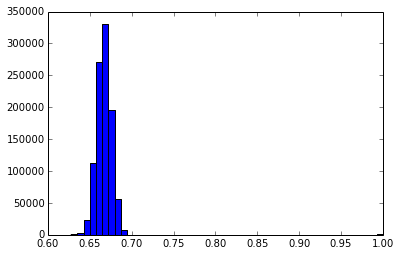

In [167]:
N=1000; # observed subjects
Ne=1000; # unobserved independent ancestors
rng=np.random.RandomState(123); # init random seed

# Draw random phenotypic values for each ancestor
Pe=rng.randn(Ne);

# First part: Make N subjects by randomly mixing the Ne independent genomes
# 1. make a vector with the mixing proportions: the genomes
G=np.zeros((N,Ne)); # their non-observed relative proportion of each of the ancestors
for i in range(0,N):
    prop=np.random.uniform(0,1,Ne);
    G[i,:]=prop/np.sum(prop);

# 2. compute the kinship matrix K
K=np.zeros((N,N)); # the real kinship matrix, based on the non-observed proportions of independent ancestral genome
for i in range(0,N):
    for j in range(i,N):
        K[i,j]=1-np.sum(np.abs(G[i]-G[j]))/2.0;
        K[j,i]=K[i,j];
mu=0;#np.mean(K.flatten());
sigma=1;#np.std(K.flatten());
K=(K-mu)/sigma;

plt.figure();
plt.hist(K.flatten(),50);

# 3. compute the genomic influence on the phenotype
Pg=G.dot(Pe);

# 4. add individual randomness to produce the observed phenotype with heritability h2
h2t=0.8;
P=h2t*Pg/np.var(Pg)+(1-h2t)*rng.randn(N);

M=100000;
a,b,h2,p_value=HasemanElstonRegression_h2(K,P,M);
print "intercept:",a;
print "slope:",b;
print "h2:",h2;
print "p_value:",p_value;

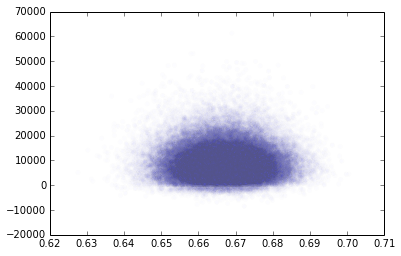

In [186]:
plotHasemanElstonRegression(K,P,M);

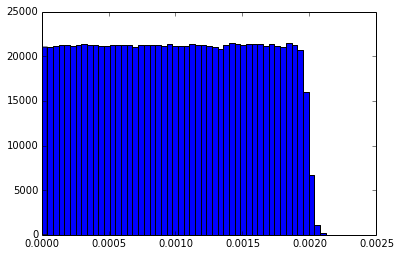

In [189]:
plt.hist(G.flatten(),50);

#Second approach
##A phenotype in a population of unrelated individuals
The observed subjects result from a combination of a smaller number of uncorrelated ancestors


In [89]:
N=10000; # observed subjects
Ne=500; # unobserved independent ancestors
rng=np.random.RandomState(123); # init random seed

# Draw random phenotypic values for each ancestor
Pe=rng.randn(Ne);

# Create N observed subjects as random combinations of Ne uncorrelated ancestors
G=rng.randn(N,Ne);
for i in range(N):
    G[i,:]/=linalg.norm(G[i,:]);

# Compute genetic part of the N observed phenotypes
# and add noise to produce a target heritability h2t
Pg=G.dot(Pe);
h2t=0.8;
P=h2t*Pg/np.var(Pg)+(1-h2t)*rng.randn(N);

# Kinship matrix
K=np.corrcoef(G);

M=10000000;
a,b,h2,p_value=HasemanElstonRegression_h2(K,P,M);
print "intercept:",a;
print "slope:",b;
print "h2:",h2;
print "p_value:",p_value;

intercept: -0.000171856628687
slope: 0.635920530648
h2: 0.953246695457
p_value: 0.0


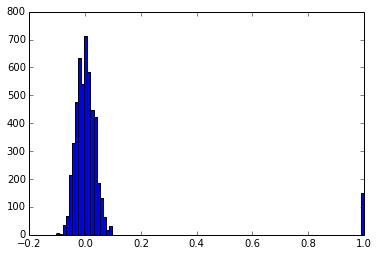

In [99]:
plt.hist(K[np.triu_indices(100)],100);

##Monozygotic and dizygotic twins

In [90]:
N=10000; # observed subjects
Ne=1000; # unobserved independent ancestors
rng=np.random.RandomState(123); # init random seed

# Draw random phenotypic values for each ancestor
Pe=rng.randn(Ne);

# Allocate memory for the genomes
G=np.zeros((N,Ne));

# Create N/4 pairs of monozygotic twins
# MZ twins share the same combination of ancestral genome
Gmz=rng.randn(N/4,Ne);
for i in range(N/4):
    G[2*i,:]=Gmz[i,:];
    G[2*i+1,:]=Gmz[i,:];

# Create N/4 pairs of dizygotic twins
# DZ twins share half of the combination of ancestral genome
Gdz=rng.randn(N/2,Ne);
for i in range(0,N/2,2):
    Gdz[i,:(Ne/2)]=Gdz[i+1,:(Ne/2)]
G[N/2:,:]=Gdz;
    
# Normalize
for i in range(N):
    G[i,:]/=linalg.norm(G[i,:]);

# Compute genetic part of the N observed phenotypes
# and add noise to produce a target heritability h2t
Pg=G.dot(Pe);
h2t=0.8;
P=h2t*Pg/np.var(Pg)+(1-h2t)*rng.randn(N);

# Kinship matrix
K=np.corrcoef(G);

# Linear regression method using a subsample of all pairs of subjects
M=10000000;
a,b,h2,p_value=HasemanElstonRegression_h2(K,P,M);
print "intercept:",intercept;
print "slope:",slope;
print "h2:",h2;
print "p_value:",p_value;

pmz1=P[range(0,N/2,2)]
pmz2=P[range(1,N/2+1,2)]
pdz1=P[range(N/2,N,2)];
pdz2=P[range(N/2+1,N,2)];
A,C,E=Falconer_h2(pmz1,pmz2,pdz1,pdz2);
print "A:",A;
print "C:",C;
print "E:",E;

intercept: 3.33321608358e-05
slope: 0.63906394837
h2: 0.898342513078
p_value: 0.0
A: 0.919888345426
C: 0.0217870569628
E: 0.0583245976116


##Correlated phenotypes in a population of unrelated individuals

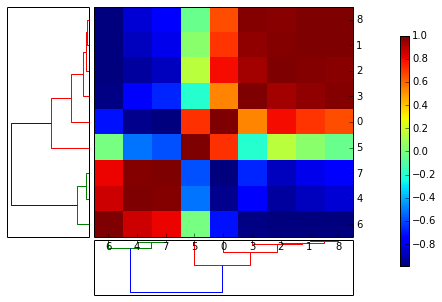

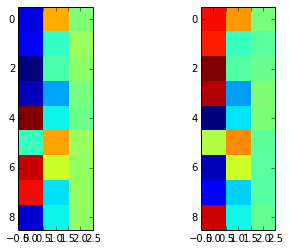

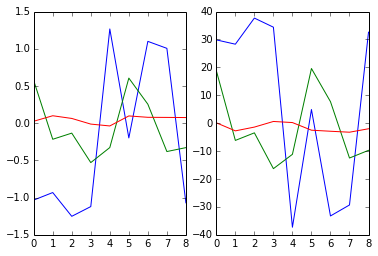

In [2]:
N=1000; # number of subjects in the observed population
Nr=9; # number of (correlated) phenotypes
Ni=3; # number of independent effects
rng = np.random.RandomState(123); # init random seed

# 1. Create (correlated) phenotypes
# Linear combination of Ni uncorrelated variables that produce the Nr correlated variables.
# (combination vectors are of unitary norm)
M=rng.randn(Nr,Ni);
for i in range(Nr):
    M[i,:]/=linalg.norm(M[i,:]);

# Scale with random eigenvalues
W=-np.sort(-np.abs(rng.randn(Ni)));
M=M.dot(np.diag(W));

# Random Ni values
Pi=rng.randn(N,Ni);

# Random Nr values produced by combining the independent Ni values
# The Nr regions are correlated among them
P=Pi.dot(M.T);
m=np.corrcoef(P.T);
plt.figure();
#plt.imshow(m,interpolation="nearest");
imshowcluster(m);

# 2. Try to guess M from P
U,S,VT=linalg.svd(P,full_matrices=False)
S=np.diag(S);
SVT=S.dot(VT);
M1=SVT[:Ni,:].T;

plt.figure();
plt.subplot(1,2,1);
plt.imshow(M,interpolation="nearest");
plt.subplot(1,2,2);
plt.imshow(M1,interpolation="nearest");

plt.figure();
plt.subplot(1,2,1);
plt.plot(M)
plt.subplot(1,2,2);
plt.plot(M1)

#X_homo = X + sigma * rng.randn(N, Nr); # Adding homoscedastic noise
#sigmas = sigma * rng.rand(Nr) + sigma / 2.0; # Adding heteroscedastic noise
#X_hetero = X + rng.randn(N, Nr) * sigmas